# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [5]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [6]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'torch': '1.8.0',
    'torchvision': '0.9.0'
}
check_packages(d)

[OK] numpy 1.26.4
[OK] scipy 1.13.0
[OK] matplotlib 3.8.4
[OK] torch 2.2.1+cu121
[OK] torchvision 0.17.1+cu121


# Chapter 14: Classifying Images with Deep Convolutional Neural Networks (Part 2/2)

**Outline**

- [Smile classification from face images using a CNN](#Constructing-a-CNN-in-PyTorch)
  - [Loading the CelebA dataset](#Loading-the-CelebA-dataset)
  - [Image transformation and data augmentation](#Image-transformation-and-data-augmentation)
  - [Training a CNN smile classifier](#Training-a-CNN-smile-classifier)
- [Summary](#Summary)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [7]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Smile classification from face images using CNN


### Loading the CelebA dataset

You can try setting `download=True` in the code cell below, however due to the daily download limits of the CelebA dataset, this will probably result in an error. Alternatively, we recommend trying the following:

- You can download the files from the official CelebA website manually (https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 
- or use our download link, https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing (recommended). 

If you use our download link, it will download a `celeba.zip` file, 

1. which you need to unpack in the current directory where you are running the code. 
2. In addition, **please also make sure you unzip the `img_align_celeba.zip` file, which is inside the `celeba` folder.**
3. Also, after downloading and unzipping the celeba folder, you need to run with the setting `download=False` instead of `download=True` (as shown in the code cell below).


**For simplicity**, you can also use my link here where I already prepared the directory structure: https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=share_link

Download that zip file and place it in the `celeba` folder. Then unzip `img_align_celeba.zip`. And it should work:
    
![](figures/celeba.webp)
    
In case you are encountering problems with this approach, please do not hesitate to open a new issue or start a discussion at https://github.com/rasbt/machine-learning-book so that we can provide you with additional information.

In [9]:
import torchvision 

image_path = './'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=True)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=True)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=True)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))

### Image transformation and data augmentation

In [ ]:
from torchvision import transforms 

## take 5 examples

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)
 
# plt.savefig('figures/14_14.png', dpi=300)
plt.show()

In [ ]:
torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Orig.', size=15)
        
    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)
    
    if i == 2:
        break
        
# plt.savefig('figures/14_15.png', dpi=300)
plt.show()

In [ ]:
get_smile = lambda attr: attr[31]
 
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])


In [ ]:
from torch.utils.data import DataLoader

celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform_train,
                                                   target_transform=get_smile)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
      
    
#plt.savefig('figures/14_16.png', dpi=300)
plt.show()



In [ ]:
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='test', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000)) 
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000)) 
 
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

In [ ]:
batch_size = 32

torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

### Training a CNN Smile classifier


In [ ]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.5)) 

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.5)) 

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())  


In [ ]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

In [13]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 3, 64, 64))
model(x).shape


torch.Size([4, 256])

In [14]:
model.add_module('fc', nn.Linear(256, 1)) 
model.add_module('sigmoid', nn.Sigmoid()) 

In [15]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [16]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [17]:
device = torch.device("cuda:0")
# device = torch.device("cpu")
model = model.to(device) 

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5151 val_accuracy: 0.5140
Epoch 2 accuracy: 0.5213 val_accuracy: 0.5560
Epoch 3 accuracy: 0.5216 val_accuracy: 0.5570
Epoch 4 accuracy: 0.5547 val_accuracy: 0.6050
Epoch 5 accuracy: 0.5878 val_accuracy: 0.6100
Epoch 6 accuracy: 0.6159 val_accuracy: 0.6250
Epoch 7 accuracy: 0.6366 val_accuracy: 0.6220
Epoch 8 accuracy: 0.6481 val_accuracy: 0.5660
Epoch 9 accuracy: 0.6672 val_accuracy: 0.6770
Epoch 10 accuracy: 0.6816 val_accuracy: 0.6660
Epoch 11 accuracy: 0.6906 val_accuracy: 0.6490
Epoch 12 accuracy: 0.7098 val_accuracy: 0.6820
Epoch 13 accuracy: 0.7321 val_accuracy: 0.7320
Epoch 14 accuracy: 0.7594 val_accuracy: 0.7930
Epoch 15 accuracy: 0.7819 val_accuracy: 0.8310
Epoch 16 accuracy: 0.8068 val_accuracy: 0.8450
Epoch 17 accuracy: 0.8241 val_accuracy: 0.8590
Epoch 18 accuracy: 0.8382 val_accuracy: 0.8680
Epoch 19 accuracy: 0.8376 val_accuracy: 0.8670
Epoch 20 accuracy: 0.8484 val_accuracy: 0.8710
Epoch 21 accuracy: 0.8512 val_accuracy: 0.8850
Epoch 22 accuracy: 0.8

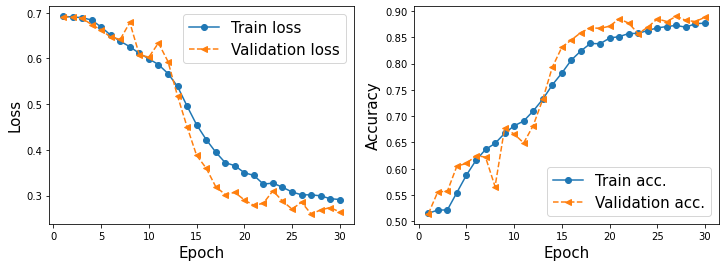

In [19]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

In [20]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()
 
accuracy_test /= len(test_dl.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}') 

Test accuracy: 0.9021


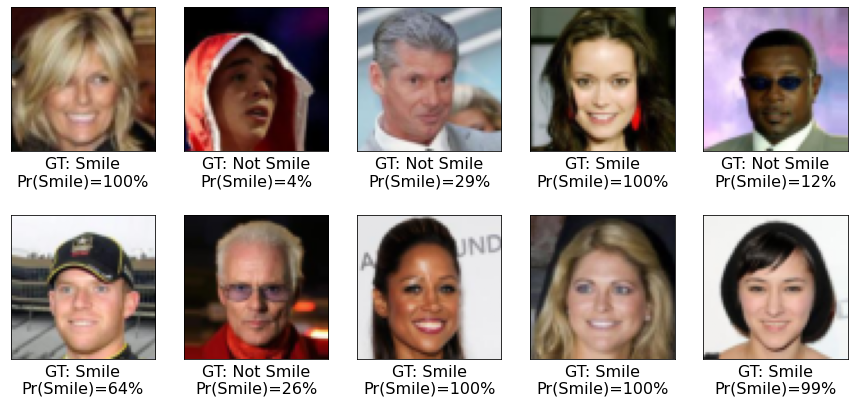

In [21]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(
        0.5, -0.15, 
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()

In [24]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/celeba-cnn.ph'
torch.save(model, path)

...


## Summary

...



----

Readers may ignore the next cell.

In [25]:
! python ../.convert_notebook_to_script.py --input ch14_part2.ipynb --output ch14_part2.py

[NbConvertApp] Converting notebook ch14_part2.ipynb to script
[NbConvertApp] Writing 14129 bytes to ch14_part2.py
